In [1]:
import rioxarray as rio
import xarray as xr
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn
import cartopy
import glob
from cartopy import crs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
from shapely import wkt
import tqdm
import multiprocessing

from moarpalettes import get_palette

## matplotlib rcParams
## IF you want to use thesis style

import requests
from io import StringIO, BytesIO

req = requests.get('https://raw.githubusercontent.com/njleach/Thesis/main/ancil/figure-style.mplstyle')

with open("/home/l/leach/thesis.mplstyle", "w") as text_file:
    text_file.write(req.content.decode())
    
plt.style.use("/home/l/leach/thesis.mplstyle")
textwidth = matplotlib.rcParams['figure.figsize'][0]

In [2]:
experiment_map = {'2022':'ERA5','1':'ENS','b2nn':'pi','b2no':'incr','b2nq':'pi','b2nr':'incr','b2ns':'pi','b2nt':'incr'}

In [3]:
def read_risk_and_agg(df_fpath):
    
    df0 = pd.read_csv(df_fpath,index_col=0)

    df0['centroid'] = df0['centroid'].apply(wkt.loads)
    df0['geometry'] = df0['geometry'].apply(wkt.loads)
    df0['centroid_epsg4326'] = df0['centroid_epsg4326'].apply(wkt.loads)

    risk_sum = df0.iloc[:,9:].sum().T.drop('Risk')
    risk_sum.index = risk_sum.index.str.split('_',expand=True)
    risk_sum = risk_sum.reset_index().rename({'level_0':'expid','level_1':'inidate','level_2':'number',0:'loss'},axis=1)
    risk_sum['experiment'] = risk_sum.expid.map(experiment_map)
    risk_sum['NUTS3'] = df_fpath.split('/')[-1].split('_')[0]
    
    return risk_sum

In [4]:
risk_fpaths = glob.glob('/network/group/aopp/predict/AWH012_LEACH_NASTORM/DATA/WISC/data/output_risk/UK/*.csv')
with multiprocessing.Pool(processes=5) as P1:
    risk_dfs = list(tqdm.tqdm(P1.imap(read_risk_and_agg, risk_fpaths),total=len(risk_fpaths)))

100%|██████████| 179/179 [04:34<00:00,  1.54s/it]


In [5]:
all_risk = pd.concat(risk_dfs)

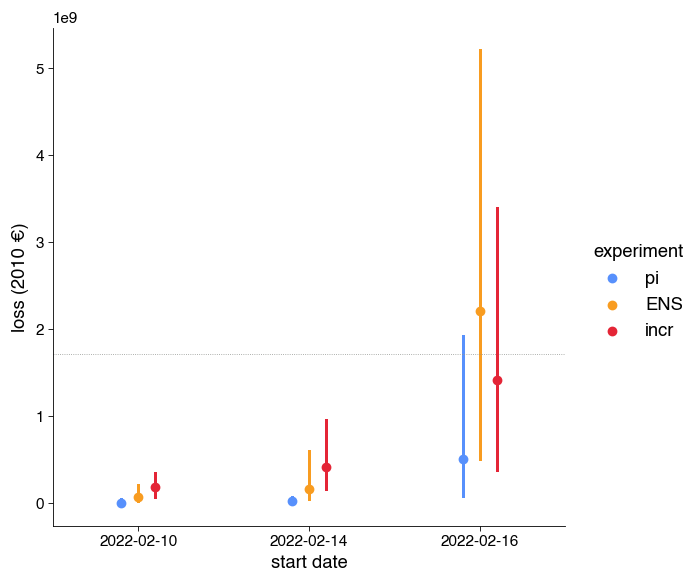

In [9]:
g=sn.catplot(data=all_risk.groupby(['experiment','number','inidate']).sum().reset_index(),x='inidate',y='loss',hue='experiment',hue_order=['pi','ENS','incr'],dodge=0.2,errorbar=('pi',33),estimator=np.median,join=False,palette=get_palette.Petroff6().to_sn_palette(),kind='point')
g.refline(y=all_risk.query('experiment=="ERA5"').loss.sum(),ls=':',color='xkcd:grey',lw=0.5)
g.set(ylabel='loss (2010 €)',xlabel='start date')
sn.despine()